In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

Reference (please appreciate and upvote the original authors):
- https://www.kaggle.com/code/saurabhbagchi/jigsaw-ensemble-tfidf-bert
- https://www.kaggle.com/julian3833/jigsaw-incredibly-simple-naive-bayes-0-768
- https://www.kaggle.com/samarthagarwal23/mega-b-ridge-to-the-top-0-84
- https://www.kaggle.com/leolu1998/jigsaw-ensemble-tfidf-bert
- https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter
- https://www.kaggle.com/debarshichanda/0-816-jigsaw-inference

# Training Data

Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [2]:
df = pd.read_csv('Jigsaw Toxic Comment Classification/train.csv', engine='python', encoding='utf8')
print(df.shape)

(159571, 8)


In [3]:
for colulmn in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f'****** {colulmn} *******')
    display(df.loc[df[colulmn]==1,['comment_text',colulmn]].sample(10))

****** toxic *******


,comment_text,toxic
140354,Piss off and get a life. I write whatever I want to write.,1
115758,block me i don't give a shit,1
71512,I want to masturbate with you. ;;,1
153850,Fuck malaysians like you'Fuck malaysians like you',1
43650,"New Section \n\nShould we write a new section talking about how gay snooker is, and how only faggots play it?",1
117954,"Don't come near my page you sad little man, stop trying to order others around in a creepy way on Wiki & get a life\n\nBardrick.",1
72491,and i suck off my own dead father,1
92719,"SPAM \n\nyou've been spammed, idiot.",1
2631,I'm sure you eat alot of tube steak,1
46675,"""\n\nFor NATE again: Nate, I don't care for your drama on my page! Please just stay the hell off and erase me from your brain like a chalk-board erasure and don't come back! You can ben anything you want on the planet except the pencil on my piece of paper ok? So, take this as a """"3R"""" rule and ...",1


****** severe_toxic *******


,comment_text,severe_toxic
32684,YOU ARE A FUCKING NERD. GO KILL YOURSELF YOU NERD.,1
119122,Suck my c*ck \n\nYou're a nazi.,1
141739,"Hey Jeremy! \n\nFUCK YOU!!! AND FUCK YOU ALAN! Good to know you mother fuckng pussies protect each other. Get a lfie with your empty threats you fucking faggot, you fucking stickingyour bare unprotected dicks within each other's assholes. FUCK YOU cocksucker!\nScratch my asshole and condensate t...",1
34703,Fucking cabal of donkey raping shit eaters I hope you all get cancer.,1
579,What a motherfucking piece of crap those fuckheads for blocking us!,1
58787,"Fuck, Shit, Damn, Cock, Pissant, Motherfucker, and horse dick.",1
139892,"you shut your whore mouth \n\n An open letter from the Wikipedia Review \n\nThis is a message to Beam,\n\nWhat the fuck do you think this is, some place where you can just waltz in unannounced and be received with arms wide open? WELL FUCK THAT! This is motherfucking Wikipedia, bitch. WE call th...",1
56920,Hey you fucking jew \nwhy the fuck did you get rid of emo kid beatdown day you aussie fag. gay jew basturd go celebrate hannucka,1
97197,)\n\nhey Mother Fucking asshole hows going . i wanna rape ur mother . and will post that video YouPorn dot com or matacafe or pornotube dot com . u tell me wher i should upload it . hehehehehehehehehehheheheeheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheheh...,1
15769,hello \n\nwill you suck my dick for $5? please reply,1


****** obscene *******


,comment_text,obscene
94649,Fucking nerd \n\nYou are a fucking nerd ass BiTCH... YOU LIL FUCKER GROW UP BITCH GET OUT YOUR MOMS BASEMENT GO GET LAID U NERD,1
98727,"""\n\n Different rules for different people \n\nI demanding an answer, why was no action taken to the user who wrote this about me?: """"""""I'll take that one. """"Blah blah blah yammer yammer yammer propagandists blah blah blah yammer yammer yammer bullshit."""" Poor little, tiny conspiracy theorist. M...",1
47390,Your a stuck up arsehole\nhave some fun for fucks sake you little cunt,1
46364,It's only rubbish to whiny little bitches that can't grasp the concept of a personal joke instead of simply pointing me to uncyclopedia and not commenting on my post.,1
125430,Darkwind \n Stick it up your arse you offensive K9. WHEN will there be accountabilty to CENSORSHIP?,1
85335,"Hey moron, I could easily log out and make edits with another username, and oh 72 hours I'm scared. Moron.",1
152633,people suck go eff a duck,1
114849,"Hey, you freaking hermaphrodite. \n\nWhen you are bored, do you bend your dick down and stick it into your vagina?",1
131836,about trina? \n\nwhat the hell going on with trina wikipedia pages?\n\nthat shit looks like crap.,1
76315,"FundRasing my Ass. \n\nSetting aside the protypical psychotic paranoid ramblings and mumblings about the dangers of Ann Coulter from the left wing kook above, I thought you Dummkopfs...er...I mean...Solar System Exploration Physicists...would be encouraged to know how WELL my PHASE II- STOP THE ...",1


****** threat *******


,comment_text,threat
116572,You're all fags for trying to delete this article. Go kill yourselves instead89.123.100.99 God Al-fucking-mighty,1
67247,"YOURE A FRREAKING JEW, AND PLEAZE COMMIT SUICIDE.",1
46155,"So fuck off and die, rape fantasising sluts",1
115860,Gross \n\nIf some bitch ever came on me I would throw her gross ass out on the pavement,1
23374,hey!!!!!!! thank you for re-editing my contributions it was really kind of you!!!!!!! i hope you get bowel cancer,1
109241,you edit \n\nYOU EDIT IS VANDAL! STOP OR DIE!,1
49364,I'LL KILL YOU ALL!!!!,1
42307,YOURE GONNA BE A DEAD FAGGOT 66.158.193.58,1
34818,"You. \n\nYou're such a sad person, the fact you FAILED RfA makes me LAUGH!\nI hope you get raped & murdered and you rot in hell you CUNT!",1
87111,"Fool! \n3RR\nPlease refrain from undoing other people's edits repeatedly. If you continue, you may be blocked from editing Wikipedia. Note that the three-revert rule prohibits making more than three reversions in a content dispute within a 24 hour period. Additionally, users who perform a large ...",1


****** insult *******


,comment_text,insult
54637,"Disgusting, ignorant decisions by our friends Schutzstaffel \n\ni AM TRULY SORRY TO SEE THAT THE ASSHOLES AT ARBCOM HAVE MANAGED TO SILENCE YET ANOTHER GOOD EDITOR. HOPEFULLY THE MORONS WILL BE VOTED OUT AND WE CAN GET THIS REVIEWED. IN THE MEANTIME I HOPE THEY DON'T PUT YOU IN A FORCED LABOR/RE...",1
26197,"Douche?\nDear S3000,\nBe you a douchecock? I believe it doubly so.",1
55346,ROB you're a fat dork.,1
130437,Mr Rajchut donot bring chamars in Saini discussion. Donot degrade any caste. All Indians are f##### by Mohammedens. There used to be a time whe Muslims used to spit into Hindus mouth after chewing Paan. Muslims also used to sleep with Rajput women. Now do not start crying.,1
47227,"Recommended Deletion Since Lack of Noteworthiness\n\nSince no one carries, much less watches, this piece of shit channel, can we pretend like it never existed in pussy liberal land by deleting this faggot page? Thanks.\n\nGo fuck yourselves with your micropenises, pussies.",1
147262,You're a fucking idiot.149.254.183.53,1
109736,"@ Okay, king of the Wikipedia Nazis! But I wasn't going to add Sony Pictures Animation's template to it and I learn my lesson. I just wanted to delete that note there because it is not need and stupid like you. Go to hell you freedom of speech killing Nazi and fuck you to hell!!",1
18406,You needsa worka on your mannersa!\nI noticed your contribution to the article: Those darned yankees! And I did not like what I saws.,1
134973,fucking fite me \n\nwhy did you edit my page youre a top class tallywacker i saw your nan in lidl,1
45475,What The Hell! \n\nDid You Even Read My Post To ICECOLDBEER Asshole!!,1


****** identity_hate *******


,comment_text,identity_hate
133505,Mmmm... yes... a pint of palestinian blood would be a fine dessert right now. - talk/email,1
27662,all chinks and gooks should be deported,1
120378,"This is just a perfect example of how Wikipedia fucks up, when a bunch of POV pushers decide they want to make an article sound as nasty as possible towards the Jews they hate so much.",1
108013,"Fattyjwoods \n\nFattyjwoods is a douche\n\nI can't believe he would like a gay team like the Yankees, well I guess you got to be one to like one.\n\np.s. \n\nFUCK GEORGE W. BUSH!",1
122095,"FUCK YOU! FUCK EVERYBODY HERE AND THEIR FUCKING GAY RULES! YOU CAN ALL BURN IN HELL, YOU SLUT, WHORE, MOTHERFUCKER, BITCH, FAGGOT, DICK, ASSHOLE, DOUCHEBAG, NIGGER, COCKSUCKER, CUNT, COW!",1
52037,"man, fuck you! you know me, you anti-semitic fucktard!!!!!!! Jesus of Suberbia",1
129609,holocaust was needed by the whole humanity,1
155400,N!GGA PU$$Y LICK B!TCH!!!!!!!!!!!!!!!!!!!!!!!,1
1288,"GHE you're a fag. Learn it, know it!",1
143151,RACIST FAGGOTS THAT MODERATE WIKIPEDIA ARE GOING TO MEET THEIR MAKER,1


In [4]:
# Give more weight to severe toxic 
df['severe_toxic'] = df.severe_toxic * 2

In [5]:
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)

In [6]:
df['y'] = df['y']/df['y'].max()
df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})

df.sample(5)

,text,y
38068,fag \n\nYou are a fucking cock sucking doosh bag,0.428571
137650,"Are you referring to me, or 69.59.189.156",0.000000
43875,"""\n\nRead Wikipedia:Reliable sources, moron. Zero-authority private websites with titles like """"brainyhistory"""", which copy their erroneous information from each other, are not. If you want a real source, try the New York Times, September 25, 1958, p. 66. """,0.000000
85891,I said Ph.D in science but that's besides the point. Explain why the author of the document should not be quoted as the most basic information about this article? Are we Nazis that burn books too? Why censor the authors themselves? What justification? And primary source is a good source. However...,0.000000
137528,Commons deletion \n\nTwo images you created are up for deletion at commons.,0.000000


In [7]:
df['y'].value_counts()

0.000000    143346
0.142857      6360
0.428571      4064
0.285714      3439
0.714286      1064
0.571429       938
0.857143       329
1.000000        31
Name: y, dtype: int64

## Create 3 versions of data: toxic, clean & ruddit

### TOXIC

In [8]:
n_folds = 7

frac_1 = 0.7
frac_1_factor = 1.5

for fold in range(n_folds):
  print(f'Fold: {fold}')
  tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fold+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fold+1))], axis=0).sample(frac=1, random_state = 10*(fold+1))

  tmp_df.to_csv(f'working/df_fld{fold}.csv', index=False)
  print(tmp_df.shape)
  print(tmp_df['y'].value_counts())



Fold: 0
(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
Fold: 1
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
Fold: 2
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
Fold: 3
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
Fold: 4
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
Fold: 5
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.

### CLEANED TOXIC

In [9]:
def clean(data, col):

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # Patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    
    return data

In [10]:
# Test clean function
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy \n \n kkdsfj
1,hi how / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [11]:
df = clean(df,'text')

n_folds = 7

frac_1 = 0.7
frac_1_factor = 1.5

for fold in range(n_folds):
    print(f'Fold: {fold}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fold+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fold+1))], axis=0).sample(frac=1, random_state = 10*(fold+1))

    tmp_df.to_csv(f'working/df_clean_fld{fold}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
Fold: 1
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
Fold: 2
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
Fold: 3
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
Fold: 4
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
Fold: 5
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.

### RUDDIT DATA

(5838, 5)


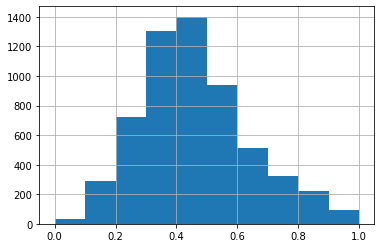

In [12]:
df_ = pd.read_csv('ruddit-jigsaw-dataset/ruddit_with_text.csv')
print(df_.shape)

df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text', 'offensiveness_score':'y'})

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

In [13]:
n_folds = 7

frac_1 = 0.7

for fold in range(n_folds):
    print(f'Fold: {fold}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fold+1))
    tmp_df.to_csv(f'working/df2_fld{fold}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.400964      1
0.889722      1
0.582976      1
0.404711      1
0.761242      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.364561     88
           ... 
0.851713      1
0.859743      1
0.051927      1
0.666488      1
0.594754      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.261777      1
0.238223      1
0.123126      1
0.694861      1
0.309422      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.238223      1
0.561028      1
0.404711      1
0.806210      1
0.184154      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [14]:
del tmp_df, df_; 

# Load Validation and Test Data

In [15]:
# Validation data 

df_val = pd.read_csv("Jigsaw Rate Severity/validation_data.csv")

In [16]:
# Test data

df_sub = pd.read_csv("Jigsaw Rate Severity/comments_to_score.csv")

# Create Sklearn Pipeline 

### Train pipeline

- Load folds data
- Train pipeline
- Predict on validation data
- Predict on test data

Toxic data

In [17]:
val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

for fold in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fold} ******************************')
    df = pd.read_csv(f'working/df_fld{fold}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge()),
        ]
    )

    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity
    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1[:,fold] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2[:,fold] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr[:,fold] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(28394, 2)

Train:

Total number of features: 146616
[('vect3__uck', 0.53),
 ('vect3__fuc', 0.49),
 ('vect3__ ass', 0.4),
 ('vect3__fuck', 0.38),
 ('vect3__ f ', 0.34),
 ('vect3__ass', 0.32),
 ('vect3__fag', 0.32),
 ('vect3__shit', 0.31),
 ('vect3__ f*', 0.3),
 ('vect3__ fag', 0.29),
 ('vect3__gay', 0.28),
 ('vect3__nig', 0.28),
 ('vect3__nl3', 0.28),
 ('vect3__ fu', 0.27),
 ('vect3__dick', 0.27),
 ('vect3__hit', 0.27),
 ('vect3__nigg', 0.27),
 ('vect3__ck ', 0.26),
 ('vect3__fuk', 0.26),
 ('vect3__ g ', 0.25),
 ('vect3__ nl', 0.25),
 ('vect3__ die', 0.24),
 ('vect3__ gay', 0.24),
 ('vect3__dum', 0.24),
 ('vect3__gga', 0.24),
 ('vect3__kill ', 0.24),
 ('vect3__ ass.', 0.23),
 ('vect3__ u ', 0.23),
 ('vect3__cun', 0.23),
 ('vect3__igg', 0.23)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(28394, 2)

Train:

Total number of features: 145297


In [18]:
val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

for fold in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fold} ******************************')
    df = pd.read_csv(f'working/df_clean_fld{fold}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
    ])

    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge()),
        ]
    )

    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity
    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1c[:,fold] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2c[:,fold] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arrc[:,fold] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(28394, 2)

Train:

Total number of features: 133784
[('vect3__uck', 0.5),
 ('vect3__ f ', 0.48),
 ('vect3__fuc', 0.45),
 ('vect3__ ass', 0.37),
 ('vect3__fuck', 0.35),
 ('vect3__shit', 0.32),
 ('vect3__ ck', 0.31),
 ('vect3__fag', 0.31),
 ('vect3__ fu', 0.29),
 ('vect3__ass', 0.29),
 ('vect3__ k ', 0.28),
 ('vect3__ re ', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ck ', 0.27),
 ('vect3__fuk', 0.27),
 ('vect3__nig', 0.27),
 ('vect3__nl3', 0.27),
 ('vect3__ fag', 0.26),
 ('vect3__gga', 0.26),
 ('vect3__dick', 0.25),
 ('vect3__gay', 0.25),
 ('vect3__suck', 0.25),
 ('vect3__ ass.', 0.24),
 ('vect3__ g ', 0.24),
 ('vect3__ gay', 0.24),
 ('vect3__ nl', 0.24),
 ('vect3__nigg', 0.24),
 ('vect3__ ass ', 0.23),
 ('vect3__ fuk', 0.23),
 ('vect3__ rape', 0.23)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(28394, 2)

Train:

Total number of features: 13

In [19]:
val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

for fold in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fold} ******************************')
    df = pd.read_csv(f'working/df2_fld{fold}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", Ridge()),
        ]
    )

    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity
    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1_[:,fold] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2_[:,fold] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr_[:,fold] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 31907
[('vect3__fuc', 0.59),
 ('vect3__fuck', 0.59),
 ('vect3__uck', 0.55),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.52),
 ('vect3__ fu', 0.42),
 ('vect3__shit', 0.4),
 ('vect3__hit', 0.37),
 ('vect3__ shit', 0.36),
 ('vect3__fuck ', 0.34),
 ('vect3__ck ', 0.32),
 ('vect3__uck ', 0.31),
 ('vect3__shi', 0.29),
 ('vect3__ shi', 0.28),
 ('vect3__ ass ', 0.27),
 ('vect3__sex', 0.26),
 ('vect3__ ass', 0.25),
 ('vect3__ dick', 0.25),
 ('vect3__dick', 0.25),
 ('vect3__ dic', 0.24),
 ('vect3__ sex', 0.24),
 ('vect3__ sh', 0.23),
 ('vect3__shit ', 0.23),
 ('vect3__ass', 0.21),
 ('vect3__ di', 0.19),
 ('vect3__ du', 0.18),
 ('vect3__!!!', 0.18),
 ('vect3__dic', 0.18),
 ('vect3__ex ', 0.18),
 ('vect3__hit ', 0.18)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of features:

# Validate the pipeline

In [20]:
print(" Toxic data ")
p_less = val_preds_arr1.mean(axis=1)
p_more = val_preds_arr2.mean(axis=1)

print(f'Validation Accuracy is { np.round((p_less < p_more).mean() * 100,2)}')

print(" Ruddit data ")
p_less_ = val_preds_arr1_.mean(axis=1)
p_more_ = val_preds_arr2_.mean(axis=1)

print(f'Validation Accuracy is { np.round((p_less_ < p_more_).mean() * 100,2)}')

print(" Toxic CLEAN data ")
p_less_c = val_preds_arr1c.mean(axis=1)
p_more_c = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p_less_c < p_more_c).mean() * 100,2)}')

 Toxic data 
Validation Accuracy is 68.46
 Ruddit data 
Validation Accuracy is 62.57
 Toxic CLEAN data 
Validation Accuracy is 68.28


In [21]:
print("Find right weight")

wts_acc = []

for i in range(30,70,1):
    for j in range(0,20,1):
        w1 = i/100
        w2 = (100 - i - j)/100
        w3 = (1 - w1 - w2 )
        p_less_wt = w1*p_less + w2*p_less_ + w3*p_less_c
        p_more_wt = w1*p_more + w2*p_more_ + w3*p_more_c
        wts_acc.append( (w1,w2,w3, 
                         np.round((p_less_wt < p_more_wt).mean() * 100,2))
                      )
sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]

Find right weight


[(0.54, 0.29, 0.16999999999999998, 69.04),
 (0.55, 0.29, 0.15999999999999998, 69.04),
 (0.56, 0.29, 0.14999999999999997, 69.04),
 (0.64, 0.24, 0.12, 69.03),
 (0.68, 0.24, 0.07999999999999996, 69.03)]

In [22]:
w1,w2,w3,_ = sorted(wts_acc, key=lambda x:x[2], reverse=True)[0]
#print(best_wts)

p_less_wt = w1*p_less + w2*p_less_ + w3*p_less_c
p_more_wt = w1*p_more + w2*p_more_ + w3*p_more_c

## Analyze Bad Predictions
- Incorrect predictions with similar scores
- Incorrect predictions with different scores


In [23]:
df_val['p_less'] = p_less_wt
df_val['p_more'] = p_more_wt
df_val['diff'] = np.abs(p_more_wt - p_less_wt)

df_val['correct'] = (p_less_wt < p_more_wt).astype('int')

In [24]:
### Incorrect predictions with similar scores

df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)

,worker,less_toxic,more_toxic,p_less,p_more,diff,correct
21672,674,"""Why is there even an """"Edit"""" option anyway?\nMaybe if they took it off there wouldn't be as much vandalism.\n\n""","I've blocked you (again, sigh). .",0.199001,0.198984,0.000017,0
23238,666,"""It's not all of a sudden, check the article's discussion page, I have proven that he's an Arab: so, not all sources agree. Also, please do tell me what other """"numerous sources"""" you have to provide? Obviously it's a weasel word, you only have one source, same as me. This makes it at the very ...","""bomb in the Diplomat hotel 20 minutes ago...after the feast...tell the government that we will destroy everyplace."""" \n """,0.251985,0.251953,0.000033,0
467,729,"RE: Pygmy Guru \n\nI'm not asking for your support. I'm expressing my general dismay in finding my article deleted. All the time and thought put into that article was wasted. Wikipedia is the collaboration of minds and people, to create a digital encyclopedia where simple folk like myself can v...",nonsense? \n\nwho are you to tell me that my truthful info about rfk jr is nonsense?,0.261888,0.261805,0.000083,0
466,171,"RE: Pygmy Guru \n\nI'm not asking for your support. I'm expressing my general dismay in finding my article deleted. All the time and thought put into that article was wasted. Wikipedia is the collaboration of minds and people, to create a digital encyclopedia where simple folk like myself can v...",nonsense? \n\nwho are you to tell me that my truthful info about rfk jr is nonsense?,0.261888,0.261805,0.000083,0
465,9,"RE: Pygmy Guru \n\nI'm not asking for your support. I'm expressing my general dismay in finding my article deleted. All the time and thought put into that article was wasted. Wikipedia is the collaboration of minds and people, to create a digital encyclopedia where simple folk like myself can v...",nonsense? \n\nwho are you to tell me that my truthful info about rfk jr is nonsense?,0.261888,0.261805,0.000083,0
14876,513,"Jesus, how much other stuff are you white washing?","""\n\n""""The WWE Raw guest host initiative was introduced on June 15, 2009 by Donald Trump during his time as owner of the Raw franchise."""" This is Wikipedia all over. Listing stories as facts...Jesus Christ. Grow a brain, the first step might be to stop watching a product churned solely for child...",0.280798,0.280698,0.000099,0
14877,268,"Jesus, how much other stuff are you white washing?","""\n\n""""The WWE Raw guest host initiative was introduced on June 15, 2009 by Donald Trump during his time as owner of the Raw franchise."""" This is Wikipedia all over. Listing stories as facts...Jesus Christ. Grow a brain, the first step might be to stop watching a product churned solely for child...",0.280798,0.280698,0.000099,0
2934,686,"""\n\nOh hell... i will not remove my personel opionion... can't you make it simple for all and block me for 2 weeks due to my personal attack?... [here is something funny, consider it as a break for exhausting thoughts """"Lost - what happens next"""" > ] ""","Drop Dead! \n\nI'm not gonna bother with you, wait till my dad comes.",0.242709,0.242600,0.000109,0
4862,173,"""No, what you've done is prove you're clueless.\n\n1) DID YOU READ THE TAG THAT THE ADMINISTRATOR PUT AT THE TOP OF THE PAGE? OBJECTIONS ARE TO GO TO THE DISCUSSION PAGE WHILE THE PAGE IS UNDER CONSTRUCTION. STOP BEING A PEST. YOU'RE NOT HELPINGYOUR GRINDING YOUR PERSONAL AXE like an immature li...","Ciao\n\nWhats up with that ? I thought Sonny Bonno was dead. You could very well be a man I knew from Youngstown., or perhaps Michigan. But that Ciao bullshit reminds me of Charlie.....Smith was actually directed by the California office to sell off those shops. Although many times his conversat...",0.313909,0.313791,0.000118,0
4861,416,"""No, what you've done is prove you're clueless.\n\n1) DID YOU READ THE TAG THAT THE ADMINISTRATOR PUT AT THE TOP OF THE PAGE? OBJECTIONS ARE TO GO TO THE DISCUSSION PAGE WHILE THE 

In [25]:
### Some of these just look incorrectly tagged
### Incorrect predictions with dis-similar scores


df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

,worker,less_toxic,more_toxic,p_less,p_more,diff,correct
25062,246,CaliforniaAliBaba is a Bitch\nGo fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.,I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet. Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.,1.177302,0.166488,1.010814,0
25754,190,what the hell man? why did you delete my page (savannah hoard) screw you dude\n\ni mean really? if you're not gonna let me have a page then you can go fuck your fat self you 40 year old bitch\n\nyour a total bitch who goes around deleting people's pages you fucking disgust me im gonna kick your ...,""" December 2009 (UTC)\n\n Now there's typical AGW alarmist Watermelon argumentum ad hominem content-vacant suppressive authoritarian WikiNazi rottenness if ever it got posted online. Don't address Monckton's (or Nsaa's) position, but strive (with utter ineffectiveness, I might add) to fault the ...",0.993966,0.239850,0.754116,0
17192,347,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,1.040056,0.308217,0.731840,0
17193,238,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,1.040056,0.308217,0.731840,0
21059,333,fuck you \n\nyou're an idiot,"What makes you an editor? Why do you use the name of a great dead man? What is your true name, profession, country? \nShamir",0.970549,0.245772,0.724778,0
9520,102,by the way I AM A FUCKIN FAG FUCK U,"You are a troublemaker, a liar, and a malicious scumbag. If you are looking for trouble, then keep removing links from the article.",1.000642,0.287374,0.713268,0
20435,504,Fuck you niggerkite. y you deleting so much shit. fuckn loser. dont delete anymore shit. its none of your fucking business,"Bush is the man. \n\nHe had the balls to dispose of Saddam and declare war on Islamic fundamentalism. Regardless of how he went about doing it, or his interest in oil, he did it. He can have the oil, if that's what he wants in return for ridding the world of religious tyranny (hopefully startin...",0.975801,0.263068,0.712733,0
19411,46,"Ok, what is it \n\nWhy are you such a queer.. you have no power, so why the FUCK are you acting like you do. Grow up you fucking stupid shit head cock eating bastard.. seriously! Get a life, you're just a 17 yo piece of shit.",wow the guy who deleated the stuff on the Habbo NSM is leet. 88!,0.957250,0.249128,0.708122,0
14595,415,"Hello fuckhead,\nContributions my faggot asshole. You think that because im gay that i dont know shit. you are wrong. you just sit there with nothing to do with your pathetic fucking life that you decide to go and be a complete prick on wikipedia and just delete whatever the fuck u want. Thanks ...",User Syrthiss is a mot*herfuc*ker assh*ole ha ha ha,1.076641,0.382659,0.693982,0
4866,609,Hey Man\nYou are a retarded Mexican cocksucking piece of fucking shit. Please go fucking kill yourself. Wikipedia admins are lower then niggers! Fuck you!,you're a faggot for reporting handlfield,1.103808,0.424175,0.679634,0


# Predict on test data

In [26]:
# Predict using pipeline

df_sub['score'] = w1*test_preds_arr.mean(axis=1) + w2*test_preds_arr_.mean(axis=1) + w3*test_preds_arrc.mean(axis=1)

In [27]:
#test_preds_arr

In [28]:
# Correct the rank ordering

# Cases with duplicates scores

df_sub['score'].count() - df_sub['score'].nunique()

13

In [29]:
same_score = df_sub['score'].value_counts().reset_index()[:10]
same_score

,index,score
0,0.553254,2
1,0.320794,2
2,0.323360,2
3,0.288264,2
4,0.342407,2
5,0.707011,2
6,0.338967,2
7,0.167897,2
8,0.367004,2
9,0.295053,2


In [30]:
df_sub[df_sub['score'].isin(same_score['index'].tolist())]

,comment_id,text,score
1832,95080362,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.167897
2842,160935265,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.167897
4757,270227263,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.707011
4759,270227815,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.707011
5752,339478276,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.338967
5753,339478966,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.338967
5832,345043812,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.367004
5833,345043888,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.367004
5852,346641598,WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS,0.288264
5853,346641762,WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GO...,0.288264


# BERT

In [33]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.1 MB/s 
     |████████████████████████████████| 120 kB 60.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.9 MB/s 


In [34]:
%%time

import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For Transformer Models
from transformers import AutoTokenizer, AutoModel

# Utils
from tqdm import tqdm

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = 'drive/MyDrive/Colab Notebooks/roberta-base',
    test_batch_size = 64,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    'drive/MyDrive/Colab Notebooks/Jigsaw Pytorch/Loss-Fold-0.bin',
    'drive/MyDrive/Colab Notebooks/Jigsaw Pytorch/Loss-Fold-1.bin'
]

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])
df = pd.read_csv("Jigsaw Rate Severity/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Some weights of the model checkpoint at drive/MyDrive/Colab Notebooks/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 1


100%|██████████| 118/118 [00:32<00:00,  3.67it/s]
Some weights of the model checkpoint at drive/MyDrive/Colab Notebooks/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 2


100%|██████████| 118/118 [00:28<00:00,  4.09it/s]

CPU times: user 1min 4s, sys: 4.16 s, total: 1min 9s
Wall time: 1min 30s


In [35]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())

In [36]:
df_sub['score'] = df_sub['score']*0.85+preds*0.15 #0.82->0.85->0.90, 0.17->0.15->0.10

In [37]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)

In [38]:
df_sub

,comment_id,text,score
0,114890,"""\n \n\nGjalexei, you asked about whether there is an """"anti-editorializing"""" policy here. There is, and it's called wikipedia:neutral point of view. It discusses at some length the case of what we should do when writing about a subject which most of us find repugnant. Whilst you're not like...",0.218986
1,732895,"Looks like be have an abuser , can you please look into this? thanks.",0.171513
2,1139051,"I confess to having complete (and apparently blissful) ignorance of Jordan, but I've glanced at the article. Is this a woman or a soap opera!?. I don't think there was much to change in terms of the description of the various diseases. It is mentioned that she is famous for the size of her bre...",0.193989
3,1434512,"""\n\nFreud's ideas are certainly much discussed today, and I would be the first to agree that they must be grappled with and dealt with seriously, if only because of their currency. So Freud deserves a long and thorough article in Wikipedia. I believe that a balanced article would include A) e...",0.214675
4,2084821,It is not just you. This is a laundry list of stupid allegations scooped up from god-knows-where. Probably two-thirds of it has little basis in fact.,0.307967
...,...,...,...
7532,504235362,"Go away, you annoying vandal.",0.271487
7533,504235566,This user is a vandal.,0.180460
7534,504308177,""" \n\nSorry to sound like a pain, but one by following me here is a tad stalking in all honesty but I'm not too bothered about that. But the main worry is that you have just assumed badly that I was referring about you, when it is clear I wasn't. One should never jump to conclusions without ch...",0.230186
7535,504570375,Well it's pretty fucking irrelevant now I'm unblocked aint it! 81.108.7.13,0.415491
